In [52]:
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt  

In [53]:
# Size of fraud cases through time series 
df_case = pd.read_csv('cleaned_data/cleaned_fraud_claim.csv')
cols_to_replace = ['reported_date', 'open_date', 'reopen_date', 'close_date']
for col in cols_to_replace:
    df_case[col] = pd.to_datetime(df_case[col], utc=True)

df_case = df_case.sort_values("reported_date", ascending=True)

df_case.dtypes

current_account_nbr                 object
case_id                              int64
reported_date          datetime64[ns, UTC]
open_date              datetime64[ns, UTC]
close_date             datetime64[ns, UTC]
reopen_date            datetime64[ns, UTC]
gross_fraud_amt                    float64
net_fraud_amt                      float64
dtype: object

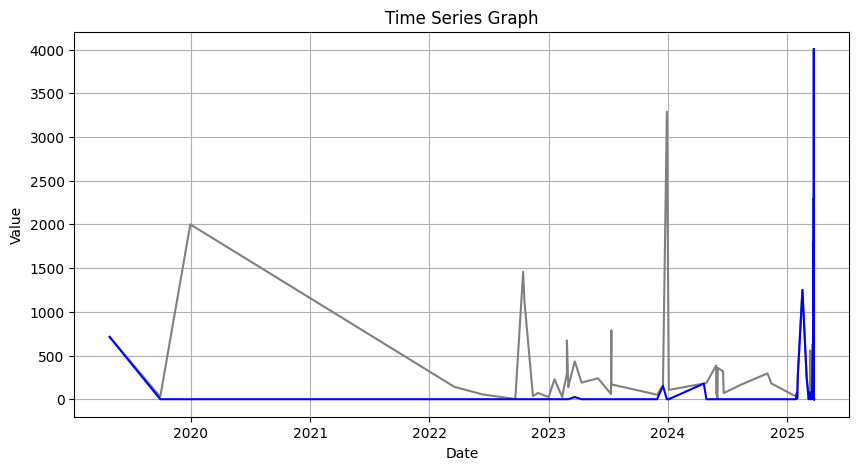

In [54]:
plt.figure(figsize=(10,5))

# plotting gross fraud & net fraud amount
plt.plot(df_case['reported_date'], df_case['gross_fraud_amt'], label='Gross Fraud Amount', color='grey')
plt.plot(df_case['reported_date'], df_case['net_fraud_amt'], label='Net Fraud Amount', color='blue')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Graph')
plt.grid(True)
plt.show()

In [ ]:
# Size of fraud transactions through time series 
df_tran = pd.read_csv('cleaned_data/cleaned_fraud_tran.csv')
cols_to_replace = ['transaction_dt']
for col in cols_to_replace:
    df_tran[col] = pd.to_datetime(df_tran[col], utc=True)

df_tran = df_tran.sort_values('transaction_dt', ascending=True)

df_tran.dtypes

current_account_nbr                 object
case_id                              int64
transaction_dt         datetime64[ns, UTC]
transaction_am                     float64
dtype: object

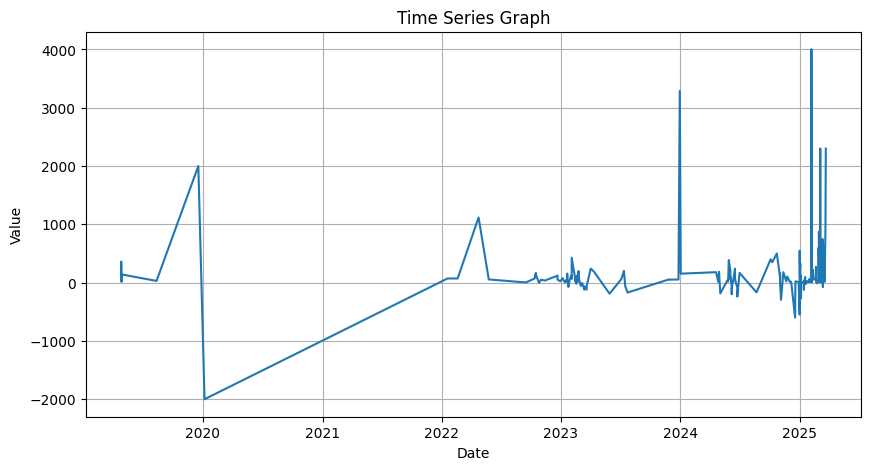

In [56]:
plt.figure(figsize=(10,5))
plt.plot(df_tran['transaction_dt'], df_tran['transaction_am'])  # Replace with your actual numeric column
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Graph')
plt.grid(True)
plt.show()

In [ ]:
# Size of fraud transactions through time series 
df_statements = pd.read_csv('cleaned_data/cleaned_fraud_tran.csv')
cols_to_replace = ['transaction_dt']
for col in cols_to_replace:
    df_tran[col] = pd.to_datetime(df_tran[col], utc=True)

df_tran = df_tran.sort_values('transaction_dt', ascending=True)

df_tran.dtypes

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df_tran['transaction_dt'], df_tran['transaction_am'])  # Replace with your actual numeric column
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Graph')
plt.grid(True)
plt.show()